In [31]:
# Import libraries
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet
from pylab import rcParams
import calendar

In [26]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [27]:
# Fill missing values
df = df.fillna(0)

In [28]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [33]:
# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

## Time series analysis

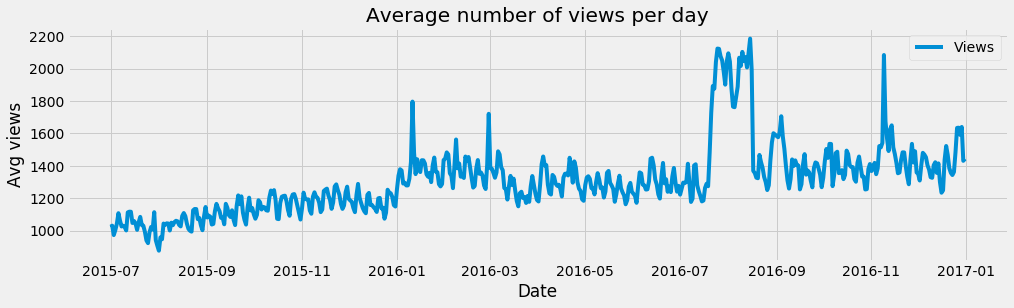

In [34]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

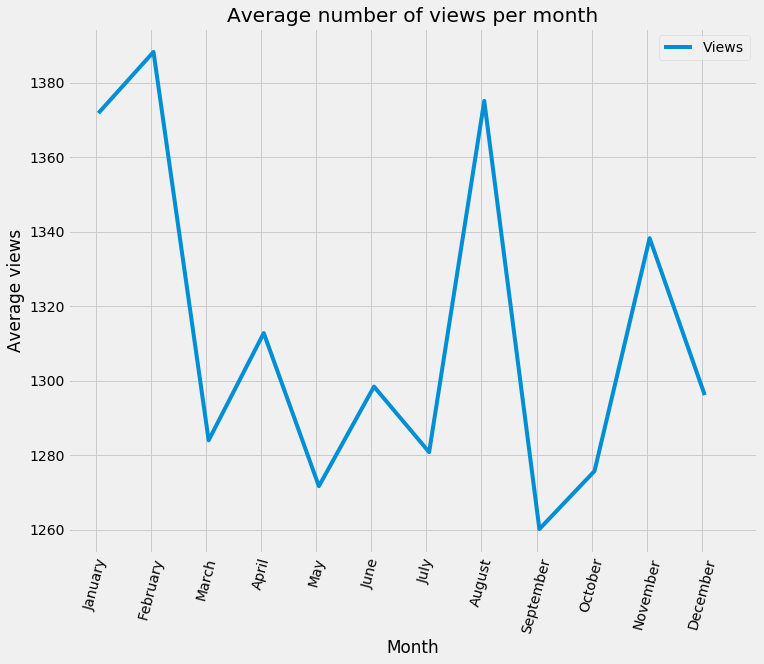

In [35]:
# Average number of views per month
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
ax.set_title('Average number of views per month')
plt.show()

In [ ]:
weekday_index = df_reshaped.index.weekday_name
views_by_weekdays = df_reshaped.groupby(weekday_index).sum()

ax = views_by_weekdays.plot()
#start, end = ax.get_xlim()
#plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
#ax.set_xticklabels(months,rotation=75)
#ax.set_xlabel('Month')
ax.set_ylabel('Total views')
plt.show()

In [ ]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
temp1 = df_reshaped  
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

In [ ]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df.head()
# lang_df = lang_df[lang_df['Page_language']!='None']
# # lang_df['Views'] = round(lang_df['Views']/1000000,0)

# bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
# bar_graph.set_ylabel('Total views (in millions)')
# bar_graph.set_title('Total number of views based on language of webpage')

# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+500))
# ax.legend()
# plt.show()

In [ ]:
df_reshaped['Dayofweek'] = df_reshaped.Date.dt.dayofweek

def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
df_reshaped['Dayofweek'] = df_reshaped.Dayofweek.apply(find_day)

In [ ]:
day = df_reshaped.groupby('Dayofweek')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [36]:
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages.nlargest(5,'Views')

,Page,Views
58761,Main_Page_en.wikipedia.org_all-access_all-agents,1.206618e+10
58763,Main_Page_en.wikipedia.org_desktop_all-agents,8.774497e+09
58764,Main_Page_en.wikipedia.org_mobile-web_all-agents,3.153985e+09
93891,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,1.603934e+09
82337,Special:Search_en.wikipedia.org_all-access_all...,1.304079e+09


In [37]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(['Main_Page_en.wikipedia.org_all-access_all-agents','Main_Page_en.wikipedia.org_desktop_all-agents','Main_Page_en.wikipedia.org_mobile-web_all-agents','Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents','Special:Search_en.wikipedia.org_all-access_all-agents'])]

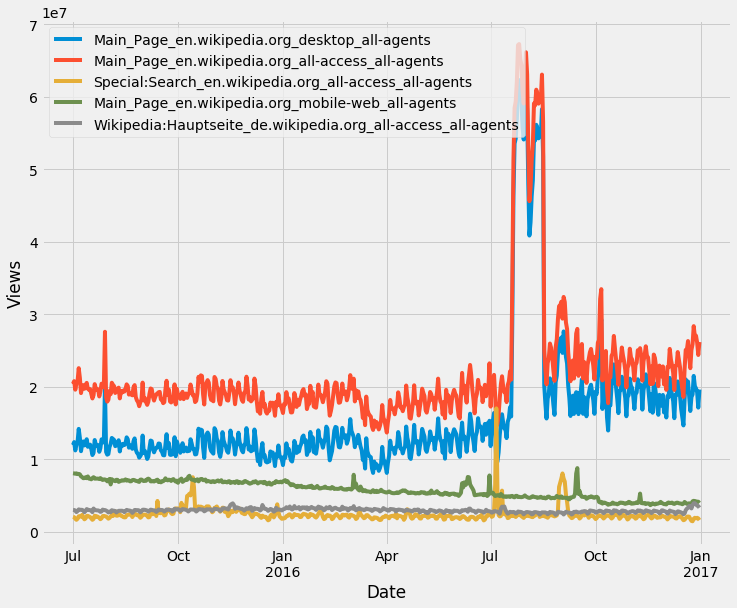

In [53]:
fig, ax = plt.subplots()
for i in list(top5_pages_df.Page.unique())[:5]:
    top5_pages_df.loc[top5_pages_df.Page == i].plot(ax=ax)
ax.set_ylabel('Views')
ax.legend(list(top5_pages_df.Page.unique())[:5],loc='upper left')
plt.show()

In [54]:
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])

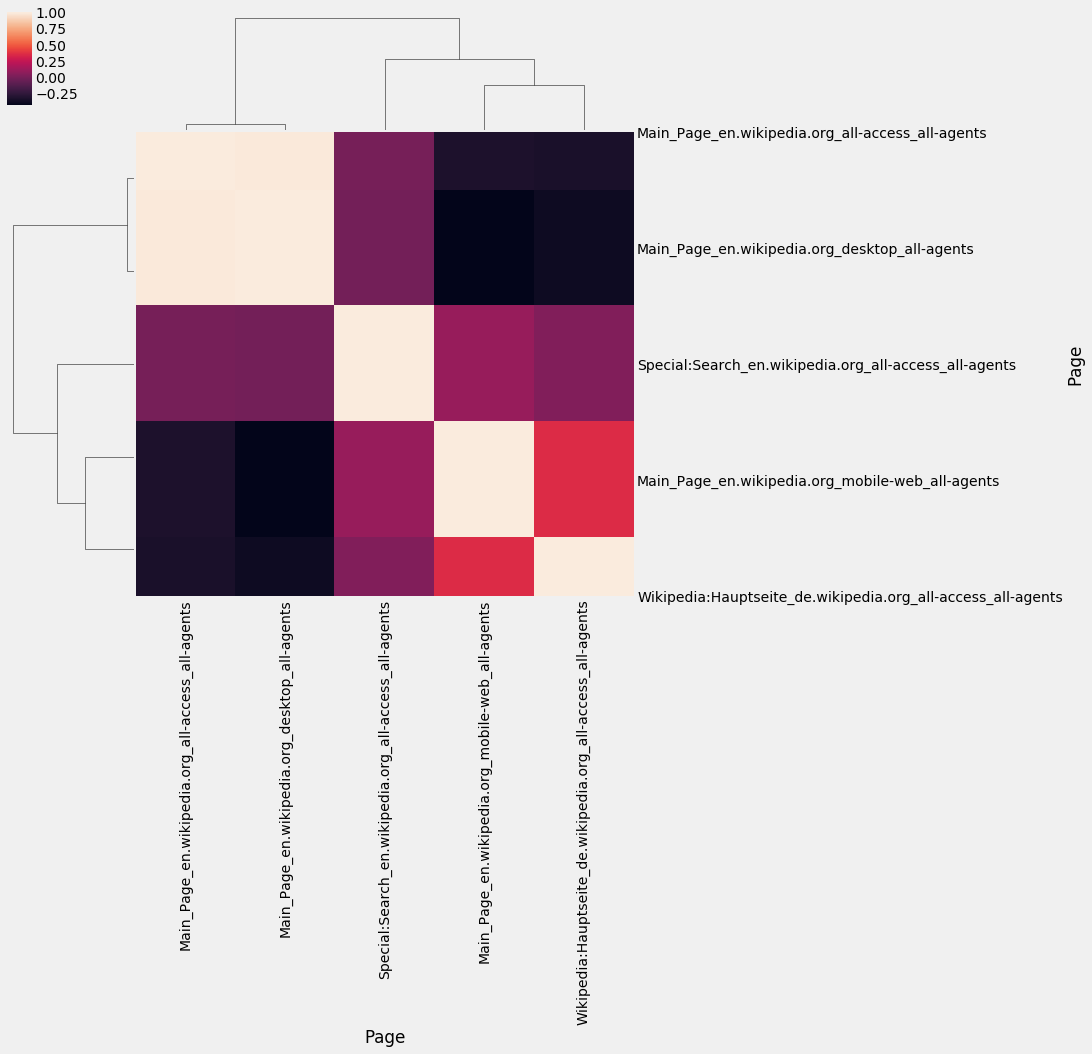

In [55]:
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [56]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


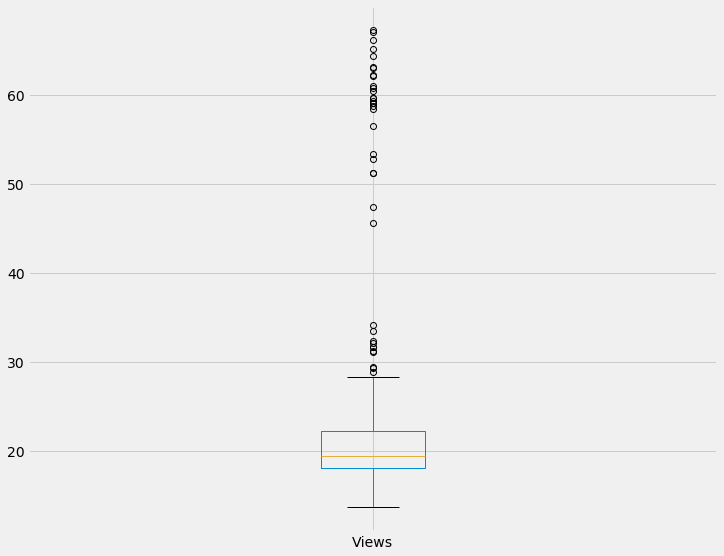

In [57]:
ax1 = top_page_df.boxplot()

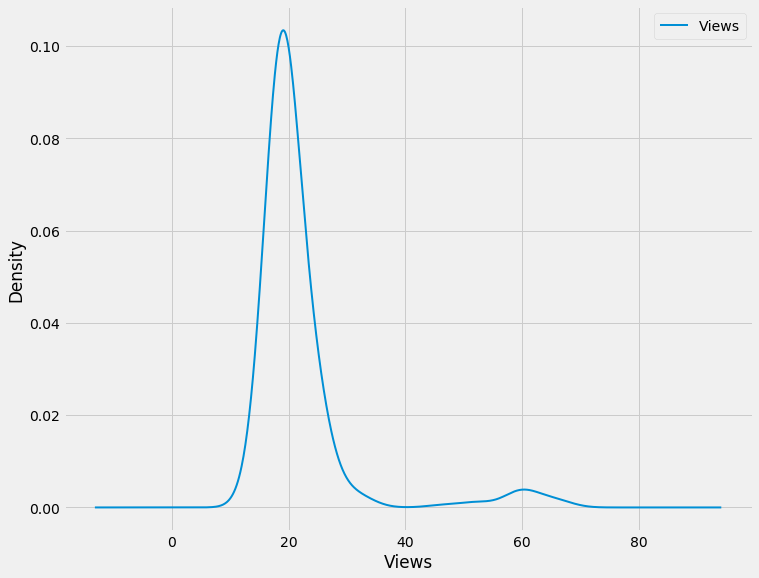

In [58]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

## Anomaly detection using Isolation Forest

In [59]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



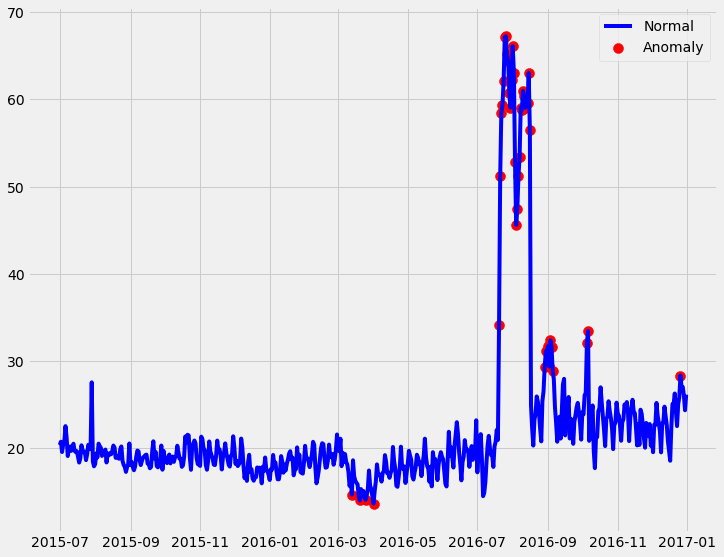

In [60]:
fig, ax = plt.subplots(figsize=(11,9))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Views'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Views'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

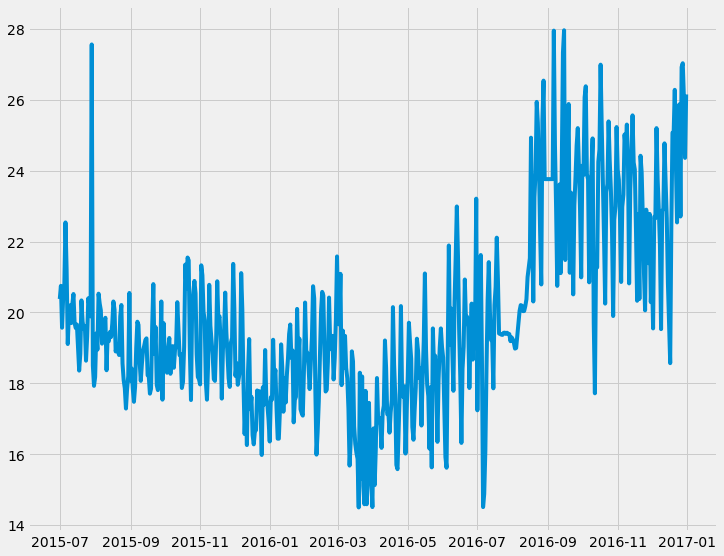

In [61]:
top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))
plt.figure(figsize=(11,9))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.show()

In [62]:
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

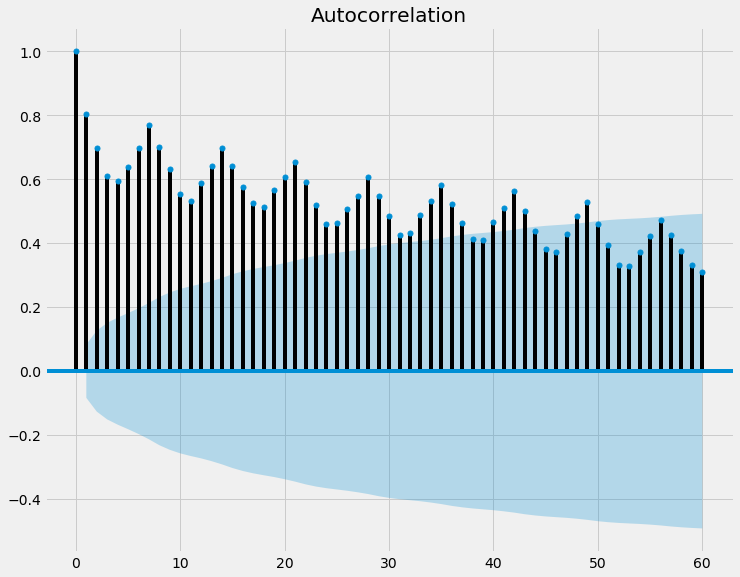

In [63]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

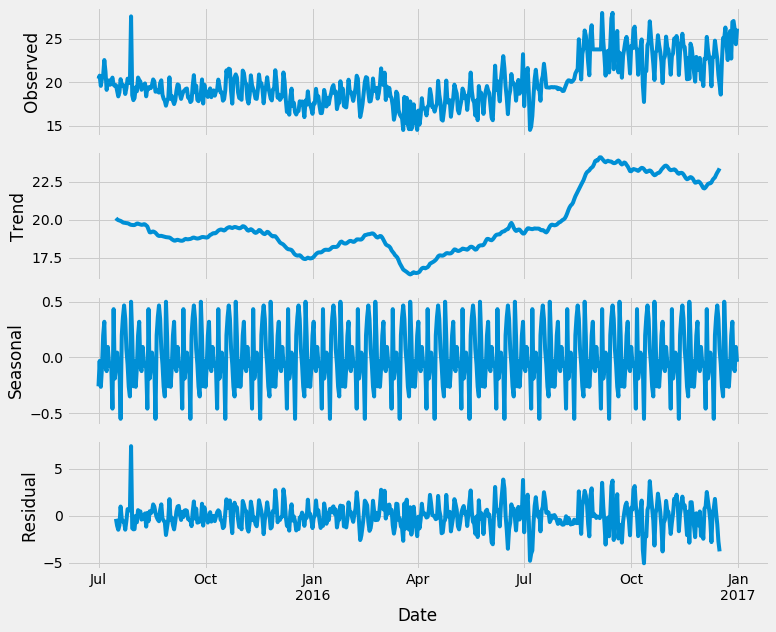

In [65]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views,freq = 30)
figure = ts_decomposition.plot()
plt.show()
# ts_decomposition.plot()

## Augmented Dicky-Fuller test

In [66]:
test = adfuller(top_page_df['Views'])
print(test)

(-0.5721224410475184, 0.8771576168694311, 15, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 1782.9243897747474)


 0th element is the test statistic. Since the value is approximately -3, we can say that the data is more likely to be stationary.
 1st element indicates the p-value. Since the p-value is < 0.05, we can reject null hypothesis.

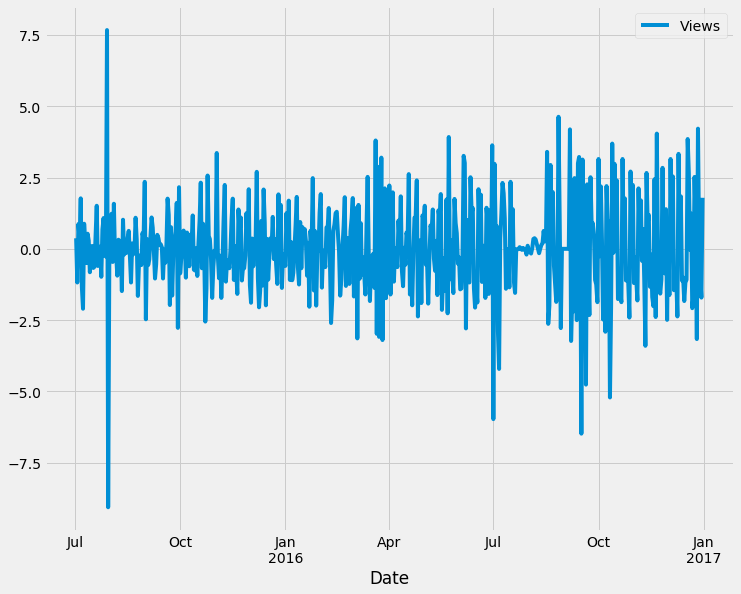

In [68]:
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [69]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-8.24385600429673, 5.622499134150291e-13, 13, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1778.8640789396934)


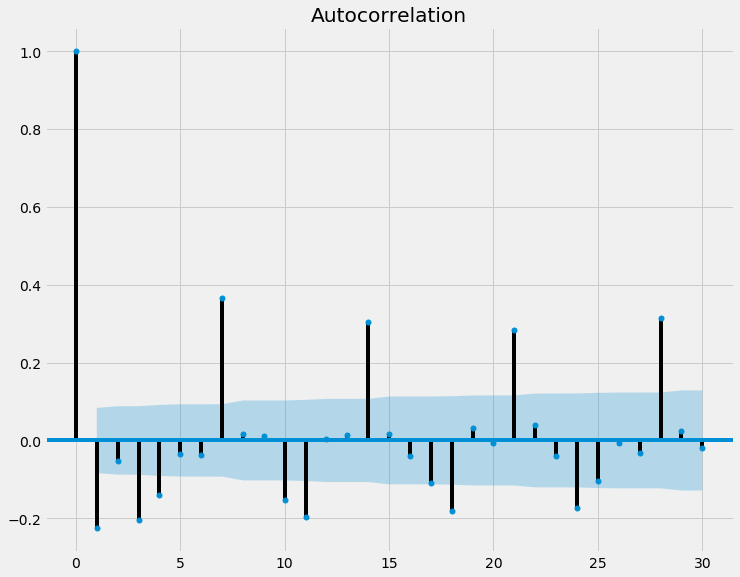

In [70]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

## Modelling

In [71]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

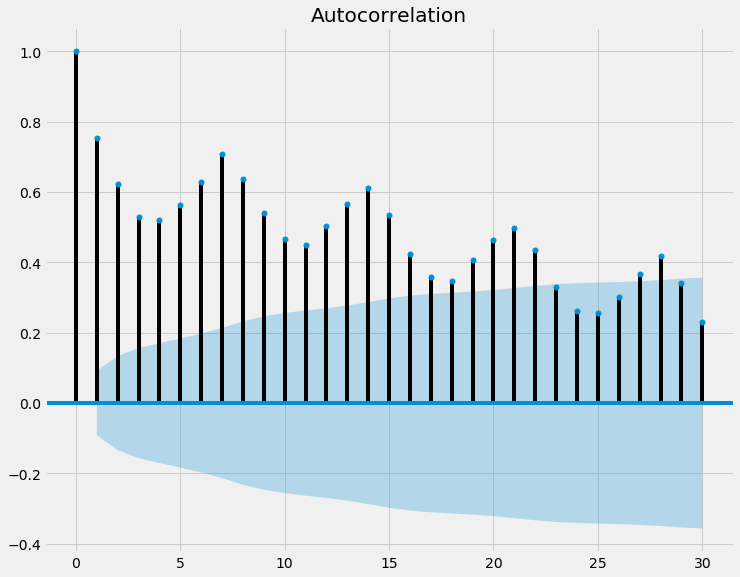

In [72]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

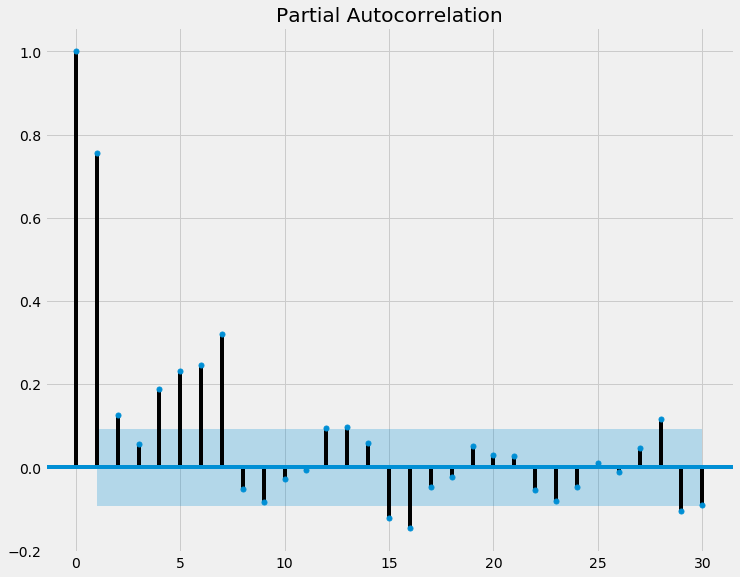

In [73]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

In [74]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
            print(p, q, result.aic, result.bic)
        except:
#             continue
            print(p,q,None,None)


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



0 0 4014.7850826791537 4018.911951863268


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



0 1 3438.3914822087927 3446.645220577021
0 2 3017.9368075724187 3030.3174151247613


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



0 3 2705.8935784741034 2722.40105521056


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



0 4 2557.0877446041786 2577.7220905247495


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



0 5 2356.3840917478756 2381.1453068525607


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



0 6 2260.305691492169 2289.1937757809683
1 0 1700.623232092746 1708.8769704609745


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 1 1631.6610323146938 1644.0416398670363


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 2 1585.256753625167 1601.7642303616237
1 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 4 1573.362538579352 1598.1237536840372
1 5 None None
1 6 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 0 1676.228259096442 1688.6088666487844
2 1 1583.2554016194645 1599.7628783559212


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 2 None None
2 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 4 1563.7982967670741 1592.6863810558734


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 5 1564.0361256556525 1597.051079128566
2 6 None None
3 0 1669.0907961548837 1685.5982728913405


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 1 1580.0594446221762 1600.6937905427471
3 2 None None
3 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency 

3 4 1485.9207749383595 1518.935728411273
3 5 None None
3 6 None None
4 0 1641.023048333584 1661.657394254155
4 1 1558.1886158433915 1582.9498309480766
4 2 None None
4 3 None None
4 4 None None
4 5 None None
4 6 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No f

5 0 1606.7371879233528 1631.498403028038


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



5 1 1547.7563697922246 1576.644454081024
5 2 None None
5 3 None None
5 4 None None
5 5 None None
5 6 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No f

6 0 1570.7279310298807 1599.61601531868


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



6 1 1538.6567204979901 1571.6716739709036


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



6 2 1515.9736466341083 1553.115469291136
6 3 None None
6 4 None None
6 5 None None
6 6 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [75]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values('aic')

In [76]:
aic_bic_df.head()

,p,q,aic,bic
17,3,4,1485.920775,1518.935728
24,6,2,1515.973647,1553.115469
23,6,1,1538.656720,1571.671674
21,5,1,1547.756370,1576.644454
19,4,1,1558.188616,1582.949831


## Fitting ARMA model

In [77]:
model = SARIMAX(train,order=(3,0,4))
result = model.fit()

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [78]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean

In [79]:
confidence_interval = forecast.conf_int()
confidence_interval.head()

,lower Views,upper Views
2016-09-01,20.620665,25.254602
2016-09-02,20.725443,25.359380
2016-09-03,21.411481,26.045413
2016-09-04,22.160932,26.794851
2016-09-05,22.413742,27.047655


## Predicting the number of views for the last 30 days using ARMA model

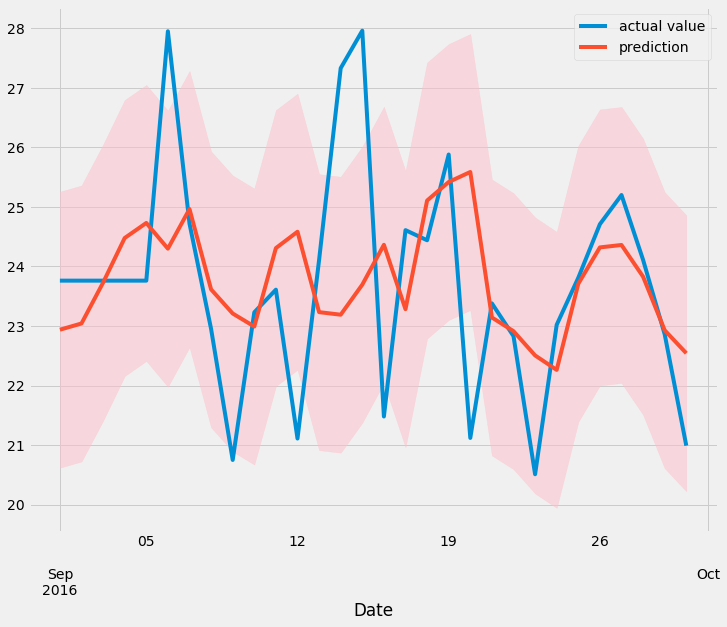

In [80]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

### Forecasting using ARMA model

In [81]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

In [82]:
arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})

In [95]:
arma_forecast_df = arma_forecast_df.set_index('Date')

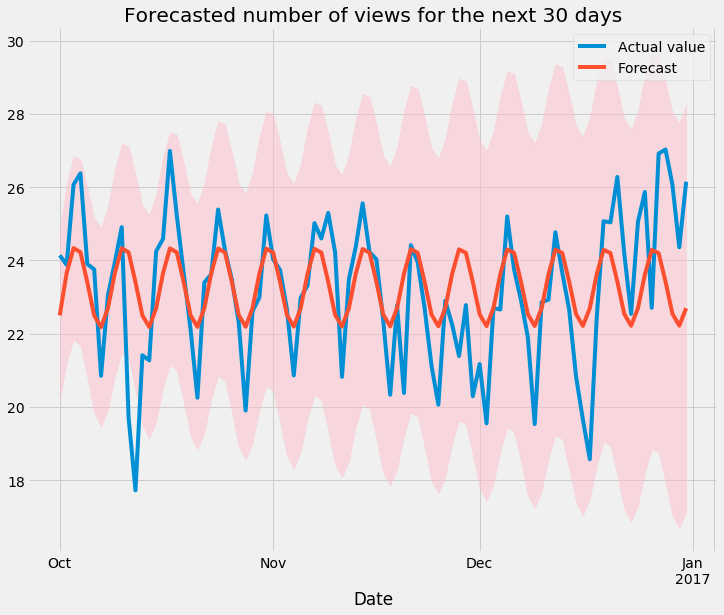

In [117]:
fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [118]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

RMSE: 1.7247848014638


## ARIMA model

In [106]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
print(arima_aic_bic_df.sort_values('aic'))

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueW

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelih

    p  q          aic          bic
20  3  3  1469.787219  1498.660003
15  2  4  1470.570919  1499.443703
29  4  6  1470.636917  1516.008434
34  5  5  1471.641207  1517.012725
16  2  5  1471.822863  1504.820330
26  4  3  1472.705052  1505.702519
17  2  6  1473.734551  1510.856702
22  3  5  1474.064904  1511.187054
35  5  6  1474.114040  1523.610240
41  6  5  1474.635588  1524.131789
23  3  6  1474.684027  1515.930861
14  2  3  1475.897607  1500.645707
42  6  6  1476.227292  1529.848176
27  4  4  1477.056586  1514.178737
21  3  4  1478.391171  1511.388639
33  5  4  1479.228563  1520.475397
28  4  5  1480.044833  1521.291667
32  5  3  1484.212401  1521.334552
39  6  3  1498.928320  1540.175154
40  6  4  1500.168985  1545.540502
36  6  0  1500.304967  1529.177751
37  6  1  1502.179890  1535.177357
38  6  2  1502.840111  1539.962262
31  5  1  1527.666629  1556.539412
25  4  1  1536.767582  1561.515682
19  3  1  1547.200376  1567.823793
12  1  6  1552.208183  1585.205650
10  1  4  1552.82736

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [107]:
arima_model = SARIMAX(train,order=(2,1,4))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



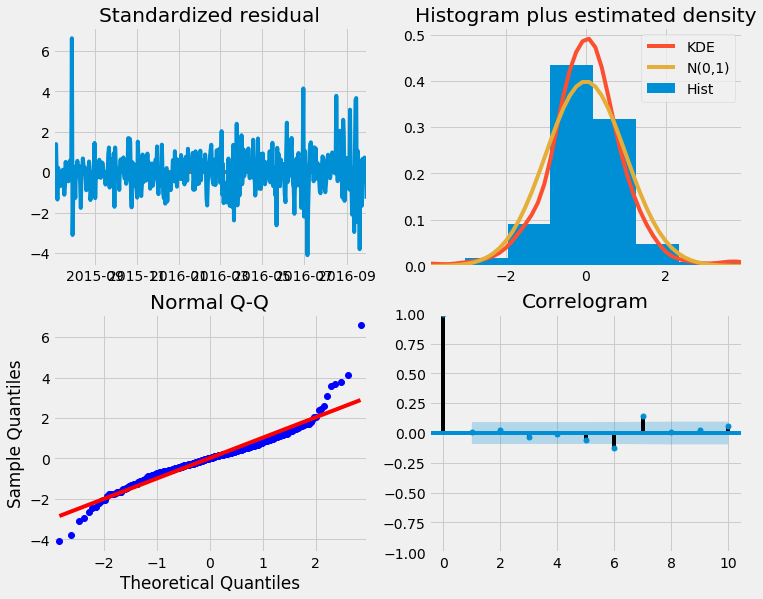

In [108]:
arima_result.plot_diagnostics()
plt.show()

In [109]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(2, 1, 4)   Log Likelihood                -728.285
Date:                Sat, 23 May 2020   AIC                           1470.571
Time:                        21:13:22   BIC                           1499.444
Sample:                    07-01-2015   HQIC                          1481.943
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2471      0.002    544.193      0.000       1.243       1.252
ar.L2         -0.9995      0.001   -758.371      0.000      -1.002      -0.997
ma.L1         -1.8982      0.033    -58.253      0.000      -1.962      -1.834
ma.L2          1.6839      0.064     26.512      0.000       1.559       1.808
ma.L3         -0.4918      0.064     -7.737      0.000      -0.616      -0.367
ma.L4         -0.1144      0.035     -3.229      0.001      -0.184      -0.045
sigma2         1.3783      0.056     24.503      0.000       1.268       1.489
===================================================================================
Ljung-Box (Q):                       50.25   Jarque-Bera (JB):               718.80
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

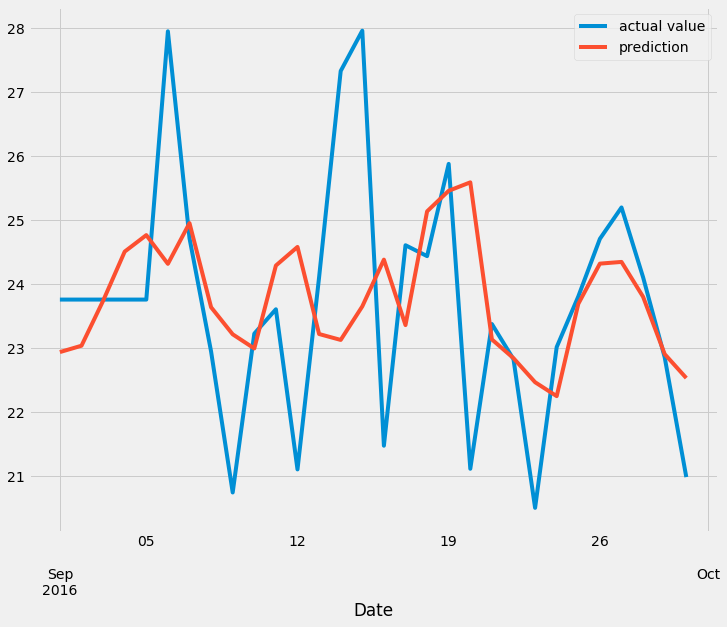

In [110]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

### Forecasting using ARIMA model

In [111]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

In [115]:
arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

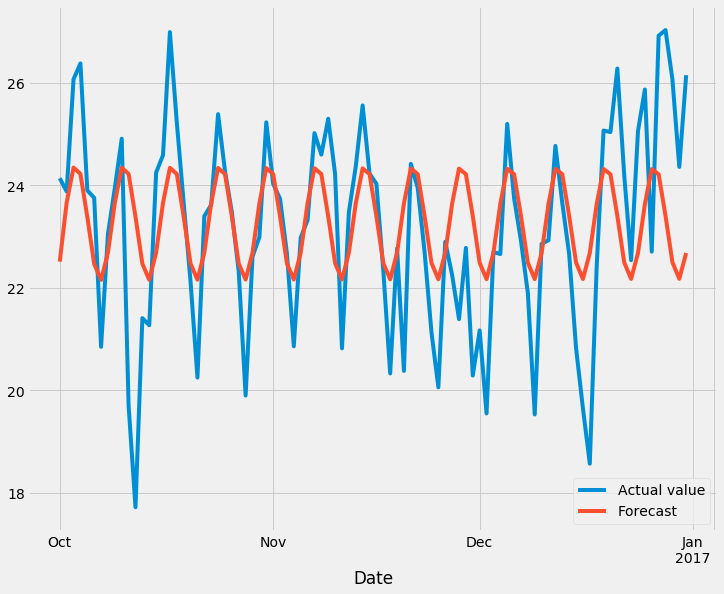

In [114]:
fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.Date, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [ ]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))

## Exponential smoothing model

In [ ]:
train.index = pd.DatetimeIndex(train.index)
start_date=train[-30:-29].index[0].date()
str_start_date = start_date.strftime("%Y-%m-%d")
end_date=train[-1:].index[0].date()
str_end_date = end_date.strftime("%Y-%m-%d")
# print(date_time)
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)
exp_smoothing_prediction = exp_smoothing_result.predict(start=str_start_date,end=str_end_date)
plt.plot(train[-30:], label='Train')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

In [ ]:
# df['Date'] = [datetime.datetime.date(d) for d in df['DateTime']] 
# val= str(datetime.date(train[-30:-29].index[0]))
# print(val)
t=train[-30:-29].index[0].date()
date_time = t.strftime("%Y-%m-%d")
print(date_time)

### Forecasting using Exponential Smoothing model

In [ ]:
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])
plt.plot(top_page_filtered)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))

## Prophet

In [ ]:
ptrain = b[:'2016-09']
ptest = b['2016-10':]
prophet_model = Prophet()
prophet_result = prophet_model.fit(ptrain.reset_index().rename(columns={'Date':'ds','Views':'y'}))

In [ ]:
future = prophet_model.make_future_dataframe(periods=ptest.shape[0])
forecast = prophet_model.predict(future)

In [ ]:
train.shape[0]

In [ ]:
prophet_forecast = forecast[['ds','yhat_lower','yhat_upper','yhat']][-ptest.shape[0]:]
plt.plot(prophet_forecast['ds'],prophet_forecast['yhat'],label='forecast')
plt.plot(b, label='Actual data')
# plt.fill_between(prophet_forecast['ds'],prophet_forecast['yhat_lower'],prophet_forecast['yhat_upper'])
plt.legend(loc='best')
plt.show()

In [ ]:
fig = prophet_model.plot_components(forecast)

In [ ]:
fig1 = prophet_model.plot(forecast)